In [1]:
import sys
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install pyLDAvis
!{sys.executable} -m pip install pandas

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 10.2 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 262 kB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 286 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 968 kB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 10.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.6 MB 3.1 MB/s eta 0:00:01
     |██████████████

     |████████████████████████████████| 829 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 99 kB 4.9 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=0398935a30fe6cdab2c77e214d3c58161af28c01cfe268c62952f3519b9b9612
  Stored in directory: /Users/emilyparrish/Library/Caches/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=3da4b7424ec224ceb727547a6fb3dc0e65776e38c79ec419152bfcc524d58306
  Stored in directory: /Users/emilyparrish/Library/Caches/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built pyLDAvis future
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION


In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [1]:
# Import Dataset

train_df = pd.read_csv('../../data/liar_dataset/train.tsv', sep='\t', names=["ID", "Label", "Content", "Subjects", "Speaker", "Job", "State", "Party", "Barely True", "False", "Half True", "Mostly True", "Pants on Fire", "Venue"])
test_df = pd.read_csv('../../data/liar_dataset/test.tsv', sep='\t', names=["ID", "Label", "Content", "Subjects", "Speaker", "Job", "State", "Party", "Barely True", "False", "Half True", "Mostly True", "Pants on Fire", "Venue"])
val_df = pd.read_csv('../../data/liar_dataset/valid.tsv', sep='\t', names=["ID", "Label", "Content", "Subjects", "Speaker", "Job", "State", "Party", "Barely True", "False", "Half True", "Mostly True", "Pants on Fire", "Venue"])


df = pd.concat([train_df, test_df, val_df])

r_df = df[df["Party"] == "republican"]
d_df = df[df["Party"] == "democrat"]

l_df = df[(df["Label"] == "false") | (df["Label"] == "barely-true") | (df["Label"] == "pants-fire") | (df["Label"] == "half-true")]
t_df = df[(df["Label"] == "true") | (df["Label"] == "mostly-true")]


NameError: name 'pd' is not defined

In [46]:
data = r_df.Content.values.tolist()

In [47]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [48]:
data_words = list(sent_to_words(data))

In [49]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['says', 'the', 'annies', 'list', 'political', 'group', 'supports', 'third', 'trimester', 'abortions', 'on', 'demand']


In [50]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [51]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!{sys.executable} -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [52]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [53]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [54]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.247*"people" + 0.061*"call" + 0.054*"ago" + 0.053*"taxpayer" + '
  '0.053*"force" + 0.052*"company" + 0.043*"build" + 0.043*"help" + '
  '0.037*"fail" + 0.035*"long"'),
 (1,
  '0.157*"budget" + 0.150*"increase" + 0.097*"come" + 0.089*"want" + '
  '0.082*"obamacare" + 0.075*"american" + 0.054*"big" + 0.040*"good" + '
  '0.029*"bring" + 0.024*"look"'),
 (2,
  '0.451*"year" + 0.116*"last" + 0.044*"number" + 0.040*"bear" + '
  '0.035*"include" + 0.030*"change" + 0.026*"life" + 0.021*"defense" + '
  '0.018*"fire" + 0.016*"total"'),
 (3,
  '0.055*"confirm" + 0.031*"defeat" + 0.000*"withdrawal" + 0.000*"maxed" + '
  '0.000*"radio" + 0.000*"consequence" + 0.000*"regardless" + '
  '0.000*"condition" + 0.000*"precipitous" + 0.000*"ground"'),
 (4,
  '0.124*"new" + 0.117*"plan" + 0.107*"money" + 0.085*"cost" + 0.080*"dollar" '
  '+ 0.071*"use" + 0.053*"nearly" + 0.042*"live" + 0.036*"immigration" + '
  '0.034*"oppose"'),
 (5,
  '0.111*"never" + 0.106*"even" + 0.086*"actually" + 0.071*"la

In [55]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.92662106839854


KeyboardInterrupt: 

In [56]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('percent', 0.39500567536889897),
   ('rate', 0.07604994324631101),
   ('income', 0.05732122587968218),
   ('unemployment', 0.041430192962542564),
   ('reduce', 0.026106696935300794),
   ('growth', 0.01872871736662883),
   ('top', 0.018161180476730987),
   ('population', 0.016458569807037457),
   ('economy', 0.012485811577752554),
   ('policy', 0.010783200908059024)]),
 (7,
  [('law', 0.11885500933416304),
   ('american', 0.0566272557560672),
   ('oil', 0.03360298693217175),
   ('reform', 0.03235843186060983),
   ('deal', 0.031113876789047916),
   ('voter', 0.023646546359676415),
   ('funding', 0.023646546359676415),
   ('education', 0.021157436216552583),
   ('thing', 0.021157436216552583),
   ('charge', 0.020535158680771624)]),
 (13,
  [('bill', 0.0743202416918429),
   ('pass', 0.05800604229607251),
   ('campaign', 0.05498489425981873),
   ('stimulus', 0.04833836858006042),
   ('fund', 0.044108761329305135),
   ('include', 0.04169184290030212),
   ('put', 0.0283987915407855),

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

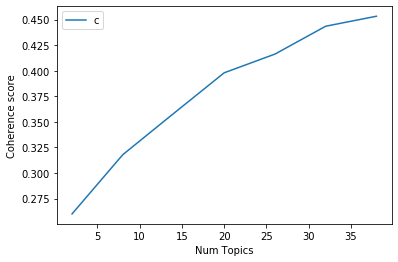

In [29]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.26
Num Topics = 8  has Coherence Value of 0.3179
Num Topics = 14  has Coherence Value of 0.3581
Num Topics = 20  has Coherence Value of 0.398
Num Topics = 26  has Coherence Value of 0.4163
Num Topics = 32  has Coherence Value of 0.4435
Num Topics = 38  has Coherence Value of 0.4533


In [31]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(19,
  '0.063*"program" + 0.061*"student" + 0.045*"show" + 0.041*"college" + '
  '0.036*"find" + 0.032*"report" + 0.031*"good" + 0.026*"kid" + 0.025*"recent" '
  '+ 0.025*"major"'),
 (18,
  '0.121*"cost" + 0.048*"dollar" + 0.044*"taxpayer" + 0.035*"send" + '
  '0.031*"service" + 0.030*"build" + 0.027*"member" + 0.023*"thousand" + '
  '0.019*"fund" + 0.017*"salary"'),
 (25,
  '0.129*"time" + 0.084*"day" + 0.066*"american" + 0.055*"run" + '
  '0.050*"office" + 0.049*"election" + 0.043*"single" + 0.031*"long" + '
  '0.024*"troop" + 0.023*"happen"'),
 (13,
  '0.238*"vote" + 0.063*"candidate" + 0.059*"president" + 0.046*"republican" + '
  '0.029*"democratic" + 0.023*"trade" + 0.022*"elect" + 0.020*"majority" + '
  '0.018*"primary" + 0.018*"executive"'),
 (1,
  '0.254*"state" + 0.078*"gun" + 0.051*"employee" + 0.031*"close" + '
  '0.028*"control" + 0.026*"local" + 0.025*"ban" + 0.020*"terrorist" + '
  '0.015*"expand" + 0.014*"weapon"'),
 (6,
  '0.068*"support" + 0.063*"law" + 0.059*"abortio

In [32]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.0786,"support, law, abortion, include, woman, oppose...",Says the Annies List political group supports ...
1,1,3.0,0.1097,"business, time, term, military, start, year, g...",When did the decline of coal start? It started...
2,2,6.0,0.0552,"support, law, abortion, include, woman, oppose...","Hillary Clinton agrees with John McCain ""by vo..."
3,3,21.0,0.0688,"bill, law, pass, call, reform, legislation, st...",Health care reform legislation is likely to ma...
4,4,3.0,0.0693,"business, time, term, military, start, year, g...",The economic turnaround started at the end of ...
5,5,2.0,0.0635,"state, number, immigration, sign, illegal, vot...",The Chicago Bears have had more starting quart...
6,6,2.0,0.0726,"state, number, immigration, sign, illegal, vot...",Jim Dunnam has not lived in the district he re...
7,7,21.0,0.0665,"bill, law, pass, call, reform, legislation, st...",I'm the only person on this stage who has work...
8,8,8.0,0.0541,"school, public, child, system, fund, funding, ...","However, it took $19.5 million in Oregon Lotte..."
9,9,13.0,0.0983,"vote, candidate, president, republican, democr...",Says GOP primary opponents Glenn Grothman and ...


In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.314078  0.288002       1        1  10.583736
2     -0.210923 -0.333935       2        1   9.834764
8     -0.111201 -0.050411       3        1   8.470998
13    -0.066916 -0.022140       4        1   6.860043
18    -0.053946 -0.016484       5        1   6.320496
4     -0.054306 -0.016526       6        1   6.266966
9     -0.021898 -0.005273       7        1   5.993010
11     0.020391  0.005136       8        1   5.077581
14     0.051675  0.010705       9        1   4.432332
1      0.039209  0.008658      10        1   4.329514
16     0.047683  0.010013      11        1   4.128954
19     0.055913  0.011301      12        1   4.030636
6      0.053907  0.011006      13        1   3.876466
0      0.066097  0.012732      14        1   3.775707
10     0.056057  0.011298      15        1   3.689155
7      0.058850  0.011745      16        1   3.680158
3      0.089283  0.015453      17        1   2.723754
17     0.090607  0.015581      18        1   2.454214
12     0.100483  0.016474      19        1   1.781620
5      0.103113  0.016664      20        1   1.689906, topic_info=    Category         Freq      Term        Total  loglift  logprob
5    Default  5273.000000       say  5273.000000  30.0000  30.0000
38   Default  2261.000000      year  2261.000000  29.0000  29.0000
97   Default  2403.000000   percent  2403.000000  28.0000  28.0000
155  Default  1409.000000     state  1409.000000  27.0000  27.0000
127  Default  1113.000000       tax  1113.000000  26.0000  26.0000
..       ...          ...       ...          ...      ...      ...
709  Topic20     0.063416      wage     1.698542   0.7927  -9.8706
552  Topic20     0.063416  lobbyist     1.698507   0.7927  -9.8706
607  Topic20     0.063415   hundred     1.698385   0.7928  -9.8706
432  Topic20     0.063420       get     1.699651   0.7921  -9.8705
468  Topic20     0.063415   current     1.698500   0.7927  -9.8706

[803 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
156       8  0.983398      able
0        12  0.988616  abortion
85        9  0.984098       act
74       15  0.993979  actually
194      17  0.990470       add
...     ...       ...       ...
129      12  0.992951     world
256       7  0.998583     would
302      10  0.814211     wrong
38        3  0.999074      year
99        1  0.973933     young

[316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 3, 9, 14, 19, 5, 10, 12, 15, 2, 17, 20, 7, 1, 11, 8, 4, 18, 13, 6])